In [1]:
import pandas as pd
df = pd.read_csv("../data/sentiment_results.csv")

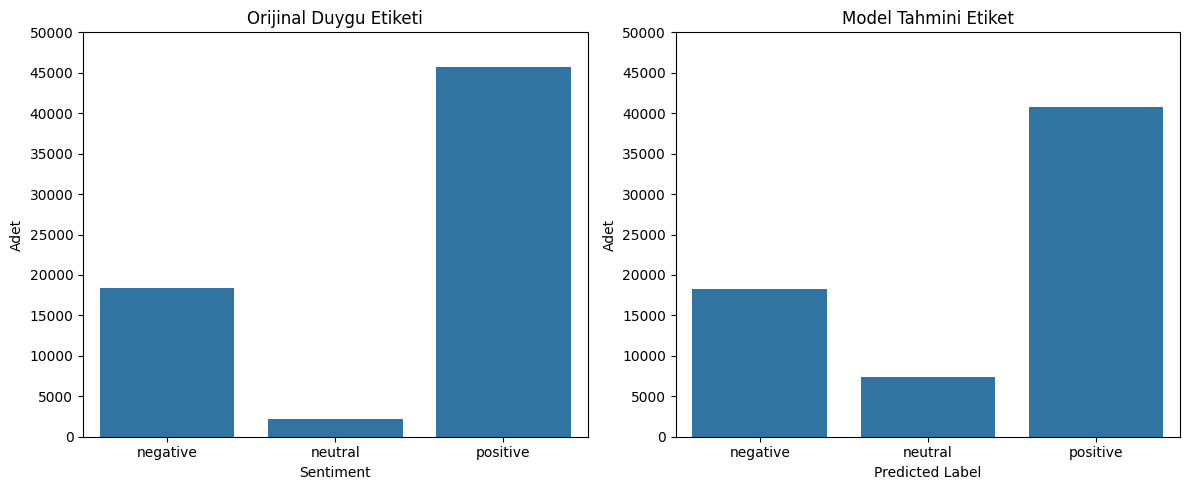

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 5))

yticks = np.arange(0, 50001, 5000) 

plt.subplot(1, 2, 1)
sns.countplot(x='sentiment', data=df)
plt.title("Orijinal Duygu Etiketi")
plt.ylim(0, 50000)
plt.yticks(yticks)
plt.xlabel("Sentiment")
plt.ylabel("Adet")

plt.subplot(1, 2, 2)
sns.countplot(x='normalized_pred_label', data=df)
plt.title("Model Tahmini Etiket")
plt.ylim(0, 50000)
plt.yticks(yticks)
plt.xlabel("Predicted Label")
plt.ylabel("Adet")

plt.tight_layout()
plt.show()


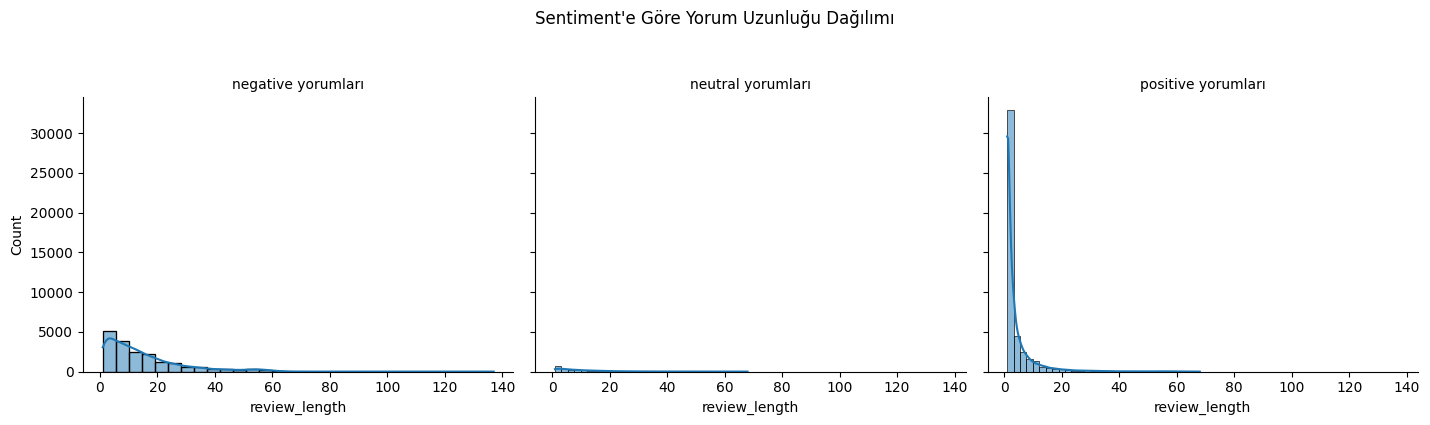

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(df, col='sentiment', height=4, aspect=1.2)
g.map(sns.histplot, 'review_length', bins=30, kde=True)
g.set_titles(col_template="{col_name} yorumları")
plt.suptitle("Sentiment'e Göre Yorum Uzunluğu Dağılımı", y=1.05)
plt.tight_layout()
plt.show()


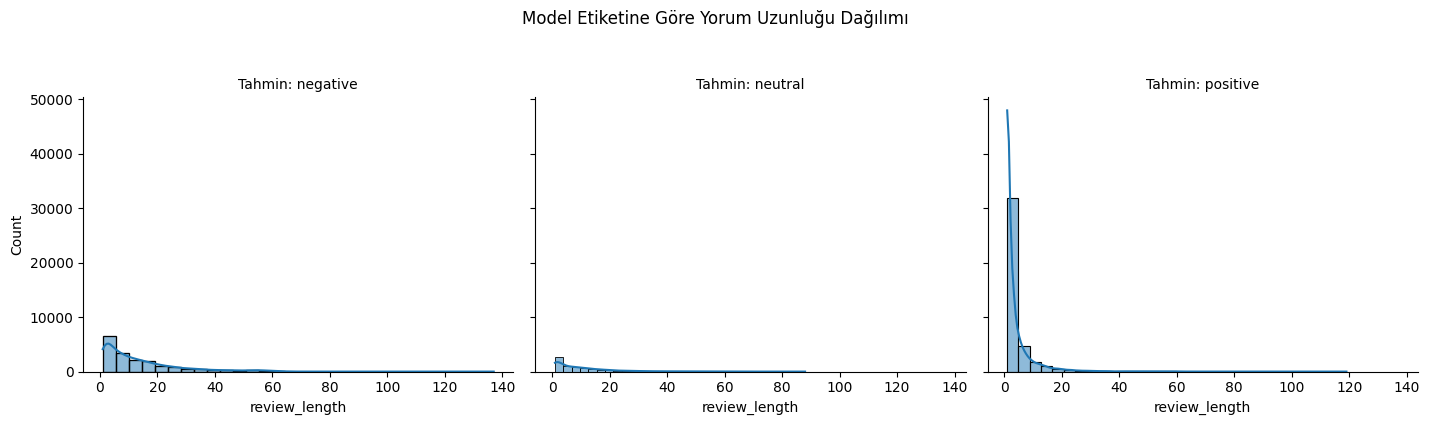

In [14]:
g = sns.FacetGrid(df, col='normalized_pred_label', height=4, aspect=1.2)
g.map(sns.histplot, 'review_length', bins=30, kde=True)
g.set_titles(col_template="Tahmin: {col_name}")
plt.suptitle("Model Etiketine Göre Yorum Uzunluğu Dağılımı", y=1.05)
plt.tight_layout()
plt.show()